** *
# 1. Preprocessing

** *
### Import data

In [1]:
#load the tweet file
import pandas as pd
user_cols = ['Name', 'ScreenName', 'UserID', 'FollowersCount', 'FriendsCount','Location','Description','CreatedAt','StatusID', 'Language', 'Place','RetweetCount','FavoriteCount','Text']
df = pd.read_csv('clinton_trump_tweets.txt', sep ='\t', encoding = "ISO-8859-1", header  = None, names = user_cols)
df.sort_values(by = ['UserID'], inplace = True)
df.shape

pd.set_option('display.max_colwidth', -1)

** *
### Drop unuseful columns and remove retweets

In [2]:
df.drop(['Name', 'ScreenName', 'Location','Description','CreatedAt','StatusID','Language','Place','RetweetCount','FavoriteCount','FollowersCount','FriendsCount'], axis=1, inplace=True)

In [3]:
df = df[df.Text.str.startswith('RT') == False]

** *
### Create a “basket” for each tweet that contains at least one hashtag or handle

In [4]:
import re
df['HH'] = df.Text.apply(lambda x : re.findall('(?:^|\s)([#|@]{1}\w+)', x))

In [5]:
# Drop the 'Text' Coloumn
df.drop(['Text'],axis = 1, inplace=True)
df.head()

,UserID,HH
1767378,150,"[@iano, @thatstacy]"
668327,150,"[@nelson, @fjordinn]"
4915364,150,[@gwestr]
697413,150,[@shinypb]
709152,150,[@fjordinn]


In [6]:
# function to return a list L combined by several lists
def combineList(L):
    res = []
    for x in L:
        for y in x:
            res.append(y)
    return res

In [7]:
# create a dataframe grouped by UserID, the hashtag_handler contains distinct HH for each users
df = pd.DataFrame({'HH' : df.groupby('UserID')['HH'].apply(lambda x:combineList(x))}).reset_index()
#df = df[df['HH'].apply(lambda x: len(set(x)) >=20)]
df.head()

,UserID,HH
0,150,"[@iano, @thatstacy, @nelson, @fjordinn, @gwestr, @shinypb, @fjordinn, @raffi, @utilizer001, @Carricohimself, @d6, @fjordinn, @flangy, @fjordinn, @Sonikku_a, @doctorow]"
1,1437,"[@JimOwczarski, @AirlineFlyer, @AirlineFlyer, #overheardinlondon, #whodeyintheUK, #whodeyintheUK]"
2,1501,[]
3,1512,"[@marypcbuk, @david_bryant, @mozilla, @SenFeinstein]"
4,1644,"[@TamieDearen, @BookNerdParadis, @JRRTolkien, #emailmarketing, #CRO, @rahdieh, @BookNerdParadis, @LorilynRoberts, @BookNerdParadis, @_awtozer, #ContentMarketing, @WillBluntAU, #blog, #contentmarketing, #promotionftw, @nick_eubanks, @MaryLovesBooks, @BookNerdParadis, @fredrivett, #5, @LaurenLynneYA, @BookNerdParadis, #listbuilding, #guestposting, @raecarson, @BookNerdParadis, @matt_hearnden, #success, #perspective, #life, #GuestBloggingStrategy, @adamjayc, @bloggingwizard, @rtmixmktg, #ContentMarketing, @RobWormley, #contentmarketing, @TolkienQuote, @EliseKova, @BookNerdParadis, @FebruaryGrace, @BookNerdParadis, @LArtra, @BookNerdParadis, #Marketing, @CodyBLister, @KatyHuthJones, @BookNerdParadis, @startrailsIV, @BookNerdParadis, #motivation, #success]"


** *
### Create a dictionary to store hashtag/handle frequency per user

In [8]:
User_dict = dict()
for index, row in df.iterrows():
    userID = row.UserID
    User_dict[userID] =dict()
    for hh in row.HH:
        if hh in User_dict[userID]:
            User_dict[userID][hh] +=1
        else:
            User_dict[userID][hh] = 1
  


In [9]:
User_dict[150] # example of one user in dictionary

{'@Carricohimself': 1,
 '@Sonikku_a': 1,
 '@d6': 1,
 '@doctorow': 1,
 '@fjordinn': 4,
 '@flangy': 1,
 '@gwestr': 1,
 '@iano': 1,
 '@nelson': 1,
 '@raffi': 1,
 '@shinypb': 1,
 '@thatstacy': 1,
 '@utilizer001': 1}

** *
### Removal of users  through iterative pruning with:
* less than 20 distinct  hashtags/handles or 20 tweets
* hashtags/handles with 20 distinct users or 20 tweets

In [10]:
# keep removing Hashtags and users until all users have 20 distinct
# and each HH shared by 20 users.
while True:
    HH_dict = dict()
    for user in User_dict:
        for hh in User_dict[user]:
            if hh in HH_dict:
                HH_dict[hh] += 1
            else:
                HH_dict[hh] = 1
    print('total users: {} , total hh: {}'.format(len(User_dict), len(HH_dict)))
    removeHH = []
    # remove HH < 20 distint users
    for hh in HH_dict:
        if HH_dict[hh] < 20:
            removeHH.append(hh)
    for hh in removeHH:
        del HH_dict[hh]
    # remove HH in userdict that is not in HH_dict
    for user in User_dict:
        removeHHinUser = []
        for hh in User_dict[user]:
            if hh not in HH_dict:
                removeHHinUser.append(hh)
        for hh in removeHHinUser:
            del User_dict[user][hh]
    # remove user who has < 20 distint HH
    removeUser = []
    for user in User_dict:
        if len(User_dict[user]) < 20:
            removeUser.append(user)
    for user in removeUser:
        del User_dict[user]
    if len(removeHH) == 0 and len(removeUser)==0:
        break
    

total users: 164797 , total hh: 640474
total users: 5053 , total hh: 6476
total users: 3853 , total hh: 2505
total users: 3662 , total hh: 2159
total users: 3629 , total hh: 2103
total users: 3622 , total hh: 2096
total users: 3619 , total hh: 2094
total users: 3619 , total hh: 2093


** *
### Create a pruned dataframe

In [11]:
UserList = list(User_dict.keys())
HHList = list(HH_dict.keys())
pruned_df = pd.DataFrame(0, index=HHList,columns=UserList)

In [19]:
type(UserList)

list

In [22]:
import csv

csvfile = "E:\CSC_177\Assingment_1\w.csv"

#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in UserList:
        writer.writerow([val]) 

In [31]:
for user in User_dict:
    for hh in User_dict[user]:
        pruned_df.loc[hh,user] = User_dict[user][hh]

In [32]:
pruned_df.head()

,1134681,1329901,1354481,1366631,1449381,1687071,1787311,2091441,2234711,2284131,...,2508827207,2511274210,2511554220,2517861180,2517885577,2519552569,2519920654,2521149576,2521541502,2521929295
#NeverTrump,2,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
#NeverHillary,2,0,0,0,0,0,0,8,13,0,...,0,0,0,0,0,0,0,0,0,0
#MAGA,1,0,0,3,0,0,0,0,11,57,...,0,0,0,0,0,1,0,3,0,0
@adamjohnsonNYC,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@PrisonPlanet,3,0,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


** *
# 2. Clustering 


** *
## Problem 1: Clustering of hashtag/handles

** *
### Normalize data by maximum absolute scaler

In [33]:
import sklearn.cluster as sk_cluster
X = pruned_df.values

In [34]:
import numpy as np
#import matplotlib.pyplot as plt
#import sklearn as sk
from sklearn import preprocessing

max_abs_scaler = preprocessing.MaxAbsScaler()
X = max_abs_scaler.fit_transform(X)

** *
### Run the k-means algorithm for k-value range 1 to 20

In [35]:
error = np.zeros(21)
for k in range(1,21):
    kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(X)
    error[k] = kmeans.inertia_
    print('running k = {}'.format(k))

running k = 1
running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
running k = 11
running k = 12
running k = 13
running k = 14
running k = 15
running k = 16
running k = 17
running k = 18
running k = 19
running k = 20


** *
### Plot of SSSE error against k value up to 20

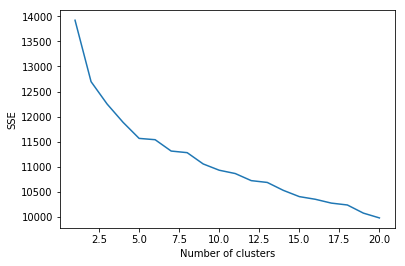

In [36]:
import matplotlib.pyplot as plt
plt.plot(range(1, 21),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

** *
### Decide K-value based on knee point and run k-mean algorithm

In [113]:
kValue = 7

In [121]:
kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=kValue, n_init=10)
kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_
error = kmeans.inertia_
print ("The total error of the clustering is: ", error)
print ('\nCluster labels')
print(kmeans_labels)
print ('\n Cluster Centroids')
print (centroids)

The total error of the clustering is:  11286.7736983

Cluster labels
[0 4 4 ..., 6 6 6]

 Cluster Centroids
[[  4.76190476e-02   1.90476190e-02   7.14285714e-02 ...,   4.82295482e-02
    3.28798186e-02   5.95238095e-03]
 [  0.00000000e+00   1.00000000e-01   0.00000000e+00 ...,   0.00000000e+00
    9.52380952e-02   0.00000000e+00]
 [  0.00000000e+00   5.00000000e-02   2.50000000e-01 ...,   1.00000000e+00
    1.90476190e-01   1.25000000e-01]
 ..., 
 [  7.69230769e-02  -8.67361738e-19   3.20512821e-02 ...,   4.14201183e-02
    3.66300366e-03   4.33680869e-19]
 [  1.11111111e-01   1.66666667e-02   7.40740741e-02 ...,   4.27350427e-02
    5.29100529e-03   0.00000000e+00]
 [  3.94866732e-03   3.13425469e-03   1.27509049e-03 ...,   2.45526109e-03
    1.85681380e-03   2.59131293e-03]]


In [122]:
kmeansClusterDIct = dict()
for i in range(1, kValue+1):
    kmeansClusterDIct[i] = []
for x in range(len(kmeans_labels)):
    kmeansClusterDIct[kmeans_labels[x]+1].append(HHList[x])

In [132]:
for i in range(1,kValue+1):
    print(len(kmeansClusterDIct[i]))

42
1
1
1
13
9
2026


** *
### Select 2 clusters for analysis

In [126]:
kmeansClusterDIct[5]

['#NeverHillary',
 '#MAGA',
 '#TrumpTrain',
 '@WDFx2EU7',
 '#draintheswamp',
 '#DrainTheSwamp',
 '#Trump',
 '#FBI',
 '#Hillary',
 '#Trump2016',
 '#TrumpPence16',
 '#CrookedHillary',
 '#HillaryClinton']

Conclusion: The context of this cluster appears to be right-wing conservatives addressing corruption in politics -- likely with regard to then presidential candidate Hillary Clinton. 

In [125]:
kmeansClusterDIct[6]

['@wikileaks',
 '@mitchellvii',
 '@FoxNews',
 '@seanhannity',
 '@megynkelly',
 '@CNN',
 '@newtgingrich',
 '@KellyannePolls',
 '@FBI']

Conclusion: The context of this cluster appears to be right-wing conservative media discussing the FBI investigation of Clintons emails which were revealed by wikileaks. 

** *
### Run SSE-based agglomerative hierarchical clustering

In [139]:
ag = sk_cluster.AgglomerativeClustering(linkage = 'ward', n_clusters = kValue)   

#complete: The maximum distances
#n_clusters: The number of clusters to find.

ag_labels = ag.fit_predict(X)

In [140]:
from scipy.cluster.hierarchy import dendrogram, linkage   
ag = linkage(X, method='ward')

In [141]:
agClusterDict = dict()
for i in range(1, kValue+1):
    agClusterDict[i] = []
for x in range(len(ag_labels)):
    agClusterDict[ag_labels[x]+1].append(HHList[x])

In [143]:
agClusterDict[1]

['@thedailybeast',
 '@kurteichenwald',
 '@jaketapper',
 '@HuffPostPol',
 '@CBSNews',
 '@nytimes',
 '@CNNPolitics',
 '@NBCNews',
 '@jasoninthehouse',
 '@thehill',
 '@CNN',
 '@KellyannePolls',
 '@JoyAnnReid',
 '@washingtonpost',
 '@ABC',
 '@FBI',
 '@politico',
 '@MSNBC']

Conclusion: Topic appears to be left-wing media outlets discussing something involving the FBI.

In [138]:
agClusterDict[6]

['#MAGA', '@YouTube', '#Trump']

Conclusion: Data here is sparse. The topic here is possibly something to do with Trump's campaign and youtube.

** *
### Difference between k-means and agglomerative hierarchical clusterings

#### K-means clusters:

In [144]:
for i in range(1,kValue+1):
    print(len(kmeansClusterDIct[i]))

42
1
1
1
13
9
2026


#### Agglomerative hierarchical clustering:

In [145]:
for i in range(1,kValue+1):
    print(len(agClusterDict[i]))

18
2
2067
1
1
3
1


They have relatively similar distributions between the two methods. However, the clustering in the k-means approach allowed for more convinient and meaningful results for manual analysis. This is due to more hashtags being allocated to comparitively more clusters.

** *
## Problem 2: Clustering of users

** *
### Take the transpose of the pruned dataframe

In [147]:
XT = X.T

** *
### Extract the truth label from the ground truth

In [148]:
user_cols = ['UserID', 'Category']
groundtruth = pd.read_csv('clinton_trump_user_classes.txt', sep ='\t', encoding = "ISO-8859-1", header  = None, names = user_cols)
groundtruth.sort_values(by=['UserID'], inplace = True)

In [149]:
groundtruth = groundtruth[groundtruth['UserID'].isin(UserList)]

In [150]:
groundtruth.head()

,UserID,Category
139005,1134681,0
22059,1329901,0
22118,1354481,0
91153,1366631,0
197078,1449381,1


In [151]:
truth_label = groundtruth.Category.tolist()

** *
### Run the k-means with 2 clusters

In [225]:
kmeans_part2 = sk_cluster.KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans_part2.fit_predict(XT)
centroids_part2 = kmeans_part2.cluster_centers_
kmeans_part2_labels = kmeans_part2.labels_
error = kmeans_part2.inertia_
print ("The total error of the clustering is: ", error)
print ('\nCluster labels')
print(kmeans_part2_labels)
print ('\n Cluster Centroids')
print (centroids_part2)

The total error of the clustering is:  12242.4265105

Cluster labels
[1 1 1 ..., 0 1 1]

 Cluster Centroids
[[ 0.01637078  0.02821041  0.08971004 ...,  0.00146557  0.0020155
   0.00014857]
 [ 0.0279906   0.02844392  0.0763142  ...,  0.00089563  0.00070155
   0.00064863]]


** *
### Generate the confusion matrix and f1-score

In [226]:
import sklearn.metrics as metrics
kMeansVsTruth = metrics.confusion_matrix(truth_label,kmeans_part2_labels)
print(kMeansVsTruth)

[[1021 1165]
 [ 358 1075]]


In [227]:
metrics.precision_score(truth_label, kmeans_part2_labels , average=None)

array([ 0.74039159,  0.47991071])

In [228]:
metrics.recall_score(truth_label, kmeans_part2_labels , average=None)

array([ 0.46706313,  0.75017446])

In [229]:
metrics.f1_score(truth_label, kmeans_part2_labels , average=None)

array([ 0.57279102,  0.58535257])

In [249]:
metrics.f1_score(truth_label, kmeans_part2_labels , average='weighted')

0.5777649668373076

** *
### Max based agglomerative and f1-score

In [198]:
ag = sk_cluster.AgglomerativeClustering(linkage = 'complete', n_clusters = 2)   
MAXag_labels = ag.fit_predict(XT)

In [199]:
ag = linkage(XT, method='complete')

In [200]:
MAXagVsTruth = metrics.confusion_matrix(truth_label,MAXag_labels)
print(MAXagVsTruth)

[[2186    0]
 [1432    1]]


In [201]:
metrics.precision_score(truth_label, MAXag_labels , average=None)

array([ 0.60420122,  1.        ])

In [202]:
metrics.recall_score(truth_label, MAXag_labels , average=None)

array([  1.00000000e+00,   6.97836706e-04])

In [203]:
metrics.f1_score(truth_label, MAXag_labels , average=None)

array([ 0.7532736,  0.0013947])

In [248]:
metrics.f1_score(truth_label, MAXag_labels , average='weighted')

0.45555532040391344

** *
### SSE based agglomerative and f-measure

In [204]:
ag = sk_cluster.AgglomerativeClustering(linkage = 'ward', n_clusters = 2)   
SSEag_labels = ag.fit_predict(XT)
SSEag_labels

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [205]:
ag = linkage(XT, method='ward')

In [206]:
SSEagVsTruth = metrics.confusion_matrix(truth_label,SSEag_labels)
print(SSEagVsTruth)

[[ 974 1212]
 [ 291 1142]]


In [207]:
metrics.precision_score(truth_label, SSEag_labels , average=None)

array([ 0.76996047,  0.48513169])

In [208]:
metrics.recall_score(truth_label, SSEag_labels , average=None)

array([ 0.44556267,  0.79692952])

In [209]:
metrics.f1_score(truth_label, SSEag_labels , average='weighted')

array([ 0.56447407,  0.60311592])

In [247]:
metrics.f1_score(truth_label, SSEag_labels , average='weighted')

0.57977491701149697

** *
### Generate the top-30 most frequently used hashtag/handles per cluster

In [230]:
print(kmeans_part2.cluster_centers_)
asc_order_centroids_part2 = kmeans_part2.cluster_centers_.argsort()    # argsort() returns the indices that would sort an array.
print(asc_order_centroids_part2)

des_order_centroids_part2 = asc_order_centroids_part2[:,::-1]     #  get the indices in descending order
print(des_order_centroids_part2)

[[ 0.01637078  0.02821041  0.08971004 ...,  0.00146557  0.0020155
   0.00014857]
 [ 0.0279906   0.02844392  0.0763142  ...,  0.00089563  0.00070155
   0.00064863]]
[[ 761 1103  491 ...,   84   17   67]
 [2015 1986 1873 ...,  111   67   17]]
[[  67   17   84 ...,  491 1103  761]
 [  17   67  111 ..., 1873 1986 2015]]


In [231]:
HHclusrerDict={}
for i in range(2):
    print ("Cluster:", i)
    HHclusrerDict[i] = []
    for ind in des_order_centroids_part2[i, :]:
        HHclusrerDict[i].append(HHList[ind])

Cluster: 0
Cluster: 1


In [241]:
c1top30 = []
for i in range(30):
    c1top30.append(HHclusrerDict[0][i])
print(c1top30, '\n')
c2top30 = []
for i in range(30):
    c2top30.append(HHclusrerDict[1][i])
print(c2top30)

['@realDonaldTrump', '@HillaryClinton', '@FoxNews', '@megynkelly', '@CNN', '@newtgingrich', '@seanhannity', '@KellyannePolls', '#MAGA', '@YouTube', '@wikileaks', '@FBI', '@mitchellvii', '@WDFx2EU7', '@mike_pence', '@washingtonpost', '@IngrahamAngle', '@MSNBC', '@jasoninthehouse', '@ABC', '@nytimes', '@POTUS', '@BreitbartNews', '#Trump', '@DonaldJTrumpJr', '@CNNPolitics', '@jaketapper', '@politico', '@PrisonPlanet', '#ImWithHer'] 

['@HillaryClinton', '@realDonaldTrump', '@CNN', '#Trump', '@YouTube', '#MAGA', '@megynkelly', '@FoxNews', '@JoyAnnReid', '@MSNBC', '@washingtonpost', '#ImWithHer', '@FBI', '@nytimes', '@wikileaks', '@kurteichenwald', '@jasoninthehouse', '#Hillary', '@KellyannePolls', '@newtgingrich', '@ABC', '@POTUS', '@seanhannity', '#HillaryClinton', '@CNNPolitics', '#CrookedHillary', '@jaketapper', '@mitchellvii', '@thehill', '@politico']


In [245]:
for x in c1top30:
    if x in c2top30:
        print(x)

@realDonaldTrump
@HillaryClinton
@FoxNews
@megynkelly
@CNN
@newtgingrich
@seanhannity
@KellyannePolls
#MAGA
@YouTube
@wikileaks
@FBI
@mitchellvii
@washingtonpost
@MSNBC
@jasoninthehouse
@ABC
@nytimes
@POTUS
#Trump
@CNNPolitics
@jaketapper
@politico
#ImWithHer


In [246]:
import operator
C1Top30_dict = dict()
C2Top30_dict = dict()
for i in range(len(kmeans_part2_labels)):
    if kmeans_part2_labels[i] == 0:
        hhlist = User_dict[UserList[i]]
        for hh in hhlist:
            if hh in C1Top30_dict:
                C1Top30_dict[hh] += hhlist[hh]
            else:
                C1Top30_dict[hh] = hhlist[hh]
    else:
        hhlist = User_dict[UserList[i]]
        for hh in hhlist:
            if hh in C2Top30_dict:
                C2Top30_dict[hh] += hhlist[hh]
            else:
                C2Top30_dict[hh] = hhlist[hh]
sorted_c1 = sorted(C1Top30_dict.items(), key=operator.itemgetter(1), reverse = True)
sorted_c2 = sorted(C2Top30_dict.items(), key=operator.itemgetter(1), reverse = True)
C1Top30_dict = sorted_c1[0:30]
C2Top30_dict = sorted_c2[0:30]
print('-----C1Top30_dict-----')
print(C1Top30_dict)
print('\n-----C2Top30_dict-----')
print(C2Top30_dict)

-----C1Top30_dict-----
[('@realDonaldTrump', 14217), ('@HillaryClinton', 7951), ('@FoxNews', 5240), ('@megynkelly', 3119), ('@CNN', 2353), ('@newtgingrich', 1845), ('@seanhannity', 1808), ('@KellyannePolls', 1706), ('@wikileaks', 1422), ('@FBI', 1332), ('#MAGA', 1325), ('@YouTube', 1248), ('@ABC', 936), ('@MSNBC', 929), ('@mitchellvii', 899), ('@mike_pence', 878), ('@POTUS', 867), ('@IngrahamAngle', 857), ('@jasoninthehouse', 838), ('@CNNPolitics', 809), ('@washingtonpost', 807), ('@WDFx2EU7', 743), ('@nytimes', 712), ('@DonaldJTrumpJr', 703), ('@BreitbartNews', 683), ('#Trump', 657), ('@GOP', 652), ('@politico', 612), ('@SpeakerRyan', 608), ('@NBCNews', 585)]

-----C2Top30_dict-----
[('@HillaryClinton', 6669), ('@realDonaldTrump', 4663), ('@YouTube', 4615), ('#Trump', 4298), ('#PJNET', 3873), ('@CNN', 3124), ('#COSProject', 3026), ('#Hillary', 2923), ('#MAGA', 2813), ('@FoxNews', 2429), ('@megynkelly', 2161), ('@MSNBC', 1876), ('#Clinton', 1702), ('@FBI', 1681), ('#TRUMP', 1662), ('#C

Conclusions: 
1. Trump supporters used more "@" mentions for Trump then clinton supporters
2. Similarly, Clinton supporters used more "@"  mentions for Clinton
3. Trump supporters most frequently mentioned news organization was Fox News
4. Clinton supporters most frequently mentioned news organization was CNN
5. Lots of overlap between the two groups according to the results
6. #Trump appears in top 30 of both groups, but the #Clinton and the like is absent  